In [1]:
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

**Load the dataset**

In [36]:
multiclass = pd.read_csv(r'C:\Users\Fra\Documents\SDS\SML\DATASET PROGETTO\multiclass_dataset.csv',header= 0)

In [47]:
first_split, second_split = train_test_split (multiclass, test_size=403,
                                              train_size=604, random_state=42,
                                              shuffle=True, stratify=None,
)

In [48]:
Training, Test = train_test_split(first_split, train_size = 480,
                                   test_size = 124, random_state=42,
                                   shuffle=True, stratify=None,
)

In [50]:
X_test = np.array(Test.drop(['label','DepMap_ID','Unnamed: 0'], axis = 1))
y_test = pd.get_dummies(Test, columns = ['label']).iloc[:,17395:17405]

X_train = np.array(Training.drop(['label','Unnamed: 0','DepMap_ID'], axis = 1))
y_train = pd.get_dummies(Training, columns = ['label']).iloc[:,17395:17405]

In [51]:
np.unique(Test['label'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [52]:
X_train_reshaped = X_train.reshape(480,17393)
X_test_reshaped = X_test.reshape(124,17393)

**First model**

In [53]:
model = Sequential()

model.add(Dense(200, input_shape=(17393,)))
model.add(Activation('relu'))
#model.add(Dropout(0.25))


model.add(Dense(10))
model.add(Activation('softmax'))
#categorical_crossentropy loss per classificazione (penalizza molto le previsioni che sono sbagliate ma con alta probabilità)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy']) #ottimizzatore che usa stochastic gradient , errore assoluto medio

early_stopping_monitor = EarlyStopping(patience= 5, monitor = 'val_accuracy')

model_chekpoint_callback = ModelCheckpoint(filepath='best_model0.hdf5',
                                           monitor = 'val_accuracy',
                                           mode = 'auto',
                                           verbose=1)

hystory = model.fit(X_train_reshaped, y_train,
         validation_data = (X_test_reshaped,y_test),
                    epochs =30,
                   callbacks = (early_stopping_monitor,model_chekpoint_callback))

#in multiclass possiamo aggiungere la softmax come activation function in modo da aumentare la probabilità che solo
#un nodo di uscita venga scelto ogni volta
#se per caso due possibili risultati sono anche parzialmente sovrapponibili si usa come activation function sigmoid

Epoch 1/30
14/15 [===========================>..] - ETA: 0s - loss: 4.0906 - accuracy: 0.1272
Epoch 00001: saving model to best_model0.hdf5
15/15 [==============================] - 1s 27ms/step - loss: 3.9546 - accuracy: 0.1354 - val_loss: 2.1560 - val_accuracy: 0.3468
Epoch 2/30
13/15 [=========================>....] - ETA: 0s - loss: 1.9390 - accuracy: 0.3870
Epoch 00002: saving model to best_model0.hdf5
15/15 [==============================] - 0s 19ms/step - loss: 1.9031 - accuracy: 0.3917 - val_loss: 1.8422 - val_accuracy: 0.4194
Epoch 3/30
13/15 [=========================>....] - ETA: 0s - loss: 1.5619 - accuracy: 0.5673
Epoch 00003: saving model to best_model0.hdf5
15/15 [==============================] - 0s 19ms/step - loss: 1.5654 - accuracy: 0.5542 - val_loss: 1.7390 - val_accuracy: 0.4677
Epoch 4/30
13/15 [=========================>....] - ETA: 0s - loss: 1.3368 - accuracy: 0.5938
Epoch 00004: saving model to best_model0.hdf5
15/15 [==============================] - 0s 19ms/s

**More complex model: increase width and depth**

In [54]:
model = Sequential()

#1°layer
model.add(Dense(600, input_shape=(17393,)))
model.add(Activation('relu'))
#model.add(Dropout(0.25))

#2°layer
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.2))

#3°layer
model.add(Dense(10))
model.add(Activation('softmax'))

#categorical_crossentropy loss per classificazione (penalizza molto le previsioni che sono sbagliate ma con alta probabilità)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy']) #ottimizzatore che usa stochastic gradient , errore assoluto medio

early_stopping_monitor = EarlyStopping(patience= 15, monitor = 'val_accuracy')

model_chekpoint_callback = ModelCheckpoint(filepath='best_model1.hdf5',
                                           monitor = 'val_accuracy',
                                           mode = 'auto',
                                           save_best_only=True,
                                           verbose=1)

hystory = model.fit(X_train_reshaped, y_train,
         validation_data = (X_test_reshaped,y_test),
                    epochs =30,
                   callbacks = (early_stopping_monitor,model_chekpoint_callback))


Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 4.3756 - accuracy: 0.1229
Epoch 00001: val_accuracy improved from -inf to 0.28226, saving model to best_model1.hdf5
15/15 [==============================] - 1s 65ms/step - loss: 4.3756 - accuracy: 0.1229 - val_loss: 2.2581 - val_accuracy: 0.2823
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 2.2402 - accuracy: 0.2521
Epoch 00002: val_accuracy improved from 0.28226 to 0.39516, saving model to best_model1.hdf5
15/15 [==============================] - 1s 52ms/step - loss: 2.2402 - accuracy: 0.2521 - val_loss: 1.9461 - val_accuracy: 0.3952
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: 1.8454 - accuracy: 0.3896
Epoch 00003: val_accuracy did not improve from 0.39516
15/15 [==============================] - 1s 36ms/step - loss: 1.8454 - accuracy: 0.3896 - val_loss: 1.9890 - val_accuracy: 0.3065
Epoch 4/30
15/15 [==============================] - ETA: 0s - loss: 1.5854 - accuracy: 0.5

15/15 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.66935
15/15 [==============================] - 1s 35ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 1.1921 - val_accuracy: 0.6452
Epoch 30/30
15/15 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.66935
15/15 [==============================] - 1s 34ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.1932 - val_accuracy: 0.6532


**Performance on test**

In [67]:
#Create the vectors that contains the Cancers chosen (Cancer_Type2) and the one observed (Cancer_Type)
Cancer_Type = ["Eye","Gastrointestinal","Genitals","Muscle-Bone","Neuro","Breast","Head_Neck","Blood",
               "Genitourinary", "Lung"] 


- Eye: 0

- Gastrointestinal: 1

- Genitals: 2

- Muscle-Bone: 3

- Neuro: 4

- Breast: 5

- Head_Neck: 6

- Blood: 7

- Urinario: 8

- Lung: 9

In [68]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                fontsize = 15,
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

In [69]:
best_model1 = load_model('best_model1.hdf5')
y_pred = np.argmax(best_model1.predict(X_test_reshaped),axis = 1)
y_pred = pd.get_dummies(y_pred, dummy_na= True)
y_pred = y_pred.T.reindex(range(10)).T.fillna(0)

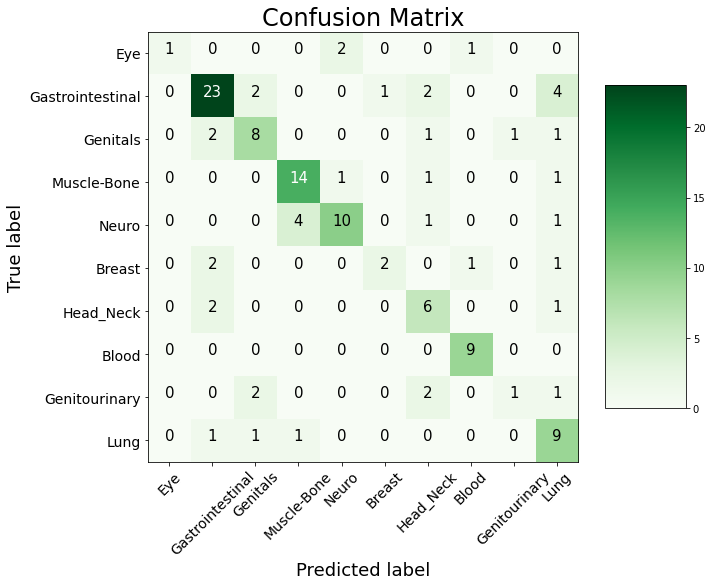

In [70]:
#Change the name of the coloumns of the class matrix created through get_dummies 
# using more meaningful names
y_test = y_test.set_axis(Cancer_Type, axis = 1)
y_pred = y_pred.set_axis(Cancer_Type, axis= 1)
y_train = y_train.set_axis(Cancer_Type, axis= 1)

y_pred = np.argmax(best_model1.predict(X_test_reshaped),axis = 1)
y_test_confusion = Test.iloc[:,17395]

cm = confusion_matrix(y_test_confusion,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')


**Try the same but with focal loss**

![Focal loss](https://lh4.googleusercontent.com/_Zb8VyevBHbPdlPS1Bcph18b0GnRdY__yrSWaxEobHAOSq5izCVXdRS0Eo-26pU5Q8JE2daQAmFlwwUKnRiaf7JJrv7VJOLXbTOF-B6G8yshVWdBwhRXFBuMB5L6eH7KCTjzen-t7e39pxku5A)

In [71]:

def categorical_focal_loss(alpha, gamma=2.):
    """
    Softmax version of focal loss.
    When there is a skew between different categories/labels in your data set, you can try to apply this function as a
    loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
      categories/labels, the size of the array needs to be consistent with the number of classes.
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

In [73]:
model = Sequential()

#1°layer
model.add(Dense(400, input_shape=(17393,)))
model.add(Activation('relu'))
model.add(Dropout(0.1))

#2°layer
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.2))

#3°layer
model.add(Dense(10))
model.add(Activation('softmax'))

#categorical_crossentropy loss per classificazione (penalizza molto le previsioni che sono sbagliate ma con alta probabilità)
model.compile(optimizer = 'adam', metrics=['accuracy'], 
    loss=[categorical_focal_loss(alpha=[.25, .25, .25, .25, .25, .25, .25, .25, .25, .25], gamma=2)])

early_stopping_monitor = EarlyStopping(patience= 15, monitor = 'val_accuracy')

model_chekpoint_callback = ModelCheckpoint(filepath='best_model_2.hdf5',
                                           monitor = 'val_accuracy',
                                           mode = 'auto',
                                           save_best_only=True,
                                           verbose=1)

hystory = model.fit(X_train_reshaped, y_train,
         validation_data = (X_test_reshaped,y_test),
                    epochs =50,
                   callbacks = (early_stopping_monitor,model_chekpoint_callback))


Epoch 1/50
13/15 [=========================>....] - ETA: 0s - loss: 0.9225 - accuracy: 0.1466
Epoch 00001: val_accuracy improved from -inf to 0.09677, saving model to best_model_2.hdf5
15/15 [==============================] - 1s 45ms/step - loss: 0.8811 - accuracy: 0.1458 - val_loss: 0.4738 - val_accuracy: 0.0968
Epoch 2/50
15/15 [==============================] - ETA: 0s - loss: 0.4986 - accuracy: 0.1958
Epoch 00002: val_accuracy improved from 0.09677 to 0.33871, saving model to best_model_2.hdf5
15/15 [==============================] - 1s 35ms/step - loss: 0.4986 - accuracy: 0.1958 - val_loss: 0.3863 - val_accuracy: 0.3387
Epoch 3/50
14/15 [===========================>..] - ETA: 0s - loss: 0.3696 - accuracy: 0.3638
Epoch 00003: val_accuracy improved from 0.33871 to 0.34677, saving model to best_model_2.hdf5
15/15 [==============================] - 1s 36ms/step - loss: 0.3735 - accuracy: 0.3583 - val_loss: 0.3674 - val_accuracy: 0.3468
Epoch 4/50
13/15 [=========================>....]

13/15 [=========================>....] - ETA: 0s - loss: 0.0019 - accuracy: 0.9976
Epoch 00029: val_accuracy did not improve from 0.63710
15/15 [==============================] - 0s 25ms/step - loss: 0.0019 - accuracy: 0.9979 - val_loss: 0.2005 - val_accuracy: 0.6371
Epoch 30/50
15/15 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9958
Epoch 00030: val_accuracy did not improve from 0.63710
15/15 [==============================] - 0s 26ms/step - loss: 0.0022 - accuracy: 0.9958 - val_loss: 0.2123 - val_accuracy: 0.6210
Epoch 31/50
13/15 [=========================>....] - ETA: 0s - loss: 0.0025 - accuracy: 0.9928
Epoch 00031: val_accuracy did not improve from 0.63710
15/15 [==============================] - 0s 25ms/step - loss: 0.0023 - accuracy: 0.9937 - val_loss: 0.2389 - val_accuracy: 0.6371
Epoch 32/50
13/15 [=========================>....] - ETA: 0s - loss: 0.0028 - accuracy: 0.9952
Epoch 00032: val_accuracy did not improve from 0.63710
15/15 [===============

In [74]:
best_model_2 = load_model('best_model_2.hdf5', compile=False)
y_pred = np.argmax(best_model_2.predict(X_test_reshaped),axis = 1)
y_pred = pd.get_dummies(y_pred)
y_pred = y_pred.T.reindex(range(10)).T.fillna(0)

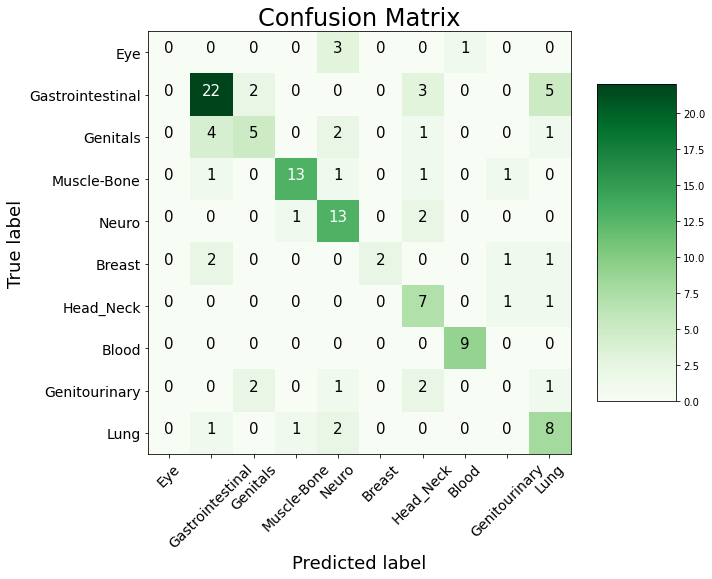

In [75]:
#Change the name of the coloumns of the class matrix created through get_dummies 
# using more meaningful names
y_test = y_test.set_axis(Cancer_Type, axis = 1)
y_pred = y_pred.set_axis(Cancer_Type, axis= 1)
y_train = y_train.set_axis(Cancer_Type, axis= 1)

y_pred = np.argmax(best_model_2.predict(X_test_reshaped),axis = 1)
y_test_confusion = Test.iloc[:,17395]

cm = confusion_matrix(y_test_confusion,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')




**Try the same but adjust alpha paramter wrt class percentage**

In [76]:
n_obs = cm.sum(axis=1)
class_perc = n_obs/sum(n_obs)

In [77]:
model = Sequential()

#1°layer
model.add(Dense(500, input_shape=(17393,)))
model.add(Activation('relu'))
model.add(Dropout(0.1))

#2°layer
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.1))

#3°layer
model.add(Dense(10))
model.add(Activation('softmax'))

#categorical_crossentropy loss per classificazione (penalizza molto le previsioni che sono sbagliate ma con alta probabilità)
model.compile(optimizer = 'adam', metrics=['accuracy'], 
    loss=[categorical_focal_loss(alpha=class_perc, gamma=2)])

early_stopping_monitor = EarlyStopping(patience= 15, monitor = 'val_accuracy')

model_chekpoint_callback = ModelCheckpoint(filepath='best_model_3.hdf5',
                                           monitor = 'val_accuracy',
                                           mode = 'auto',
                                           save_best_only=True,
                                           verbose=1)

hystory = model.fit(X_train_reshaped, y_train,
         validation_data = (X_test_reshaped,y_test),
                    epochs =50,
                   callbacks = (early_stopping_monitor,model_chekpoint_callback))


Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.1688
Epoch 00001: val_accuracy improved from -inf to 0.12903, saving model to best_model_3.hdf5
15/15 [==============================] - 1s 52ms/step - loss: 0.3396 - accuracy: 0.1688 - val_loss: 0.1974 - val_accuracy: 0.1290
Epoch 2/50
15/15 [==============================] - ETA: 0s - loss: 0.1931 - accuracy: 0.2583
Epoch 00002: val_accuracy improved from 0.12903 to 0.29032, saving model to best_model_3.hdf5
15/15 [==============================] - 1s 45ms/step - loss: 0.1931 - accuracy: 0.2583 - val_loss: 0.1626 - val_accuracy: 0.2903
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.3250
Epoch 00003: val_accuracy improved from 0.29032 to 0.41129, saving model to best_model_3.hdf5
15/15 [==============================] - 1s 46ms/step - loss: 0.1450 - accuracy: 0.3250 - val_loss: 0.1358 - val_accuracy: 0.4113
Epoch 4/50
15/15 [==============================]

Epoch 29/50
15/15 [==============================] - ETA: 0s - loss: 3.5483e-04 - accuracy: 1.0000
Epoch 00029: val_accuracy improved from 0.66129 to 0.66935, saving model to best_model_3.hdf5
15/15 [==============================] - 1s 42ms/step - loss: 3.5483e-04 - accuracy: 1.0000 - val_loss: 0.0920 - val_accuracy: 0.6694
Epoch 30/50
15/15 [==============================] - ETA: 0s - loss: 3.5388e-04 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.66935
15/15 [==============================] - 0s 30ms/step - loss: 3.5388e-04 - accuracy: 1.0000 - val_loss: 0.0898 - val_accuracy: 0.6532
Epoch 31/50
15/15 [==============================] - ETA: 0s - loss: 2.3346e-04 - accuracy: 0.9979
Epoch 00031: val_accuracy did not improve from 0.66935
15/15 [==============================] - 0s 30ms/step - loss: 2.3346e-04 - accuracy: 0.9979 - val_loss: 0.1031 - val_accuracy: 0.6532
Epoch 32/50
15/15 [==============================] - ETA: 0s - loss: 1.2719e-04 - accuracy: 1.000

In [78]:
best_model_3 = load_model('best_model_3.hdf5', compile=False)
y_pred = np.argmax(best_model_3.predict(X_test_reshaped),axis = 1)
y_pred = pd.get_dummies(y_pred)
y_pred = y_pred.T.reindex(range(10)).T.fillna(0)

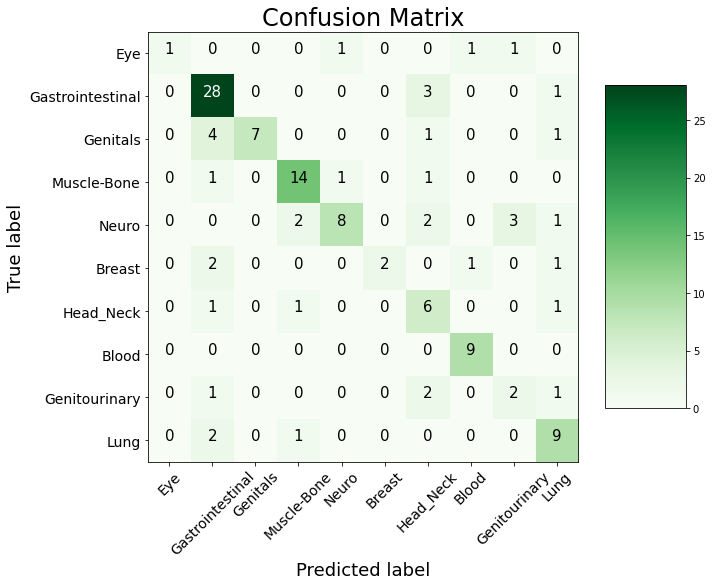

In [79]:
#Change the name of the coloumns of the class matrix created through get_dummies 
# using more meaningful names
y_test = y_test.set_axis(Cancer_Type, axis = 1)
y_pred = y_pred.set_axis(Cancer_Type, axis= 1)
y_train = y_train.set_axis(Cancer_Type, axis= 1)

y_pred = np.argmax(best_model_3.predict(X_test_reshaped),axis = 1)
y_test_confusion = Test.iloc[:,17395]

cm = confusion_matrix(y_test_confusion,y_pred)
plot_confusion_matrix(cm, classes = Cancer_Type,
                        title = 'Confusion Matrix')




No change at all :(

**Permutation importance first model**

In [ ]:
results = permutation_importance(best_model, X_test, y_test, scoring='neg_mean_squared_error')
nn_importance = results.importances_mean

In [ ]:
nn_importance[:120].plot.bar(figsize = (25, 10), color = 'r')
plt.title('Neural Network Feature Importance (Top 120)')
plt.xlabel('Features')
plt.show()